In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv("green_tripdata_2015-12.csv", usecols=["VendorID", "lpep_pickup_datetime", "Trip_distance", "Fare_amount", "Total_amount", "Payment_type"])
print(f"Original shape: {df.shape}")

Original shape: (1608290, 6)


In [2]:
df = df.copy()
for col in ("Trip_distance", "Fare_amount", "Total_amount"):
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df[df[col].notna()]
    df = df[df[col] > 0]

df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['hour'] = df['lpep_pickup_datetime'].dt.hour
df['dayofweek'] = df['lpep_pickup_datetime'].dt.dayofweek

In [3]:
X = df.drop(['Total_amount', 'lpep_pickup_datetime'], axis=1)  # Drop non-numeric columns
y = df['Total_amount'].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1106197, 6), Val: (237042, 6), Test: (237043, 6)


In [4]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,753 (1.02 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=128, callbacks=[early_stop], verbose=2)
print(f"Training completed. Final epochs: {len(history.history['loss'])}")
print(f"Best val_loss: {min(history.history['val_loss']):.4f}")

Epoch 1/50
8643/8643 - 29s - 3ms/step - loss: 0.0603 - mae: 0.1032 - val_loss: 0.0387 - val_mae: 0.0669
Epoch 2/50
8643/8643 - 28s - 3ms/step - loss: 0.0637 - mae: 0.1075 - val_loss: 0.0375 - val_mae: 0.0734
Epoch 3/50
8643/8643 - 27s - 3ms/step - loss: 0.0621 - mae: 0.1094 - val_loss: 0.0412 - val_mae: 0.0881
Epoch 4/50
8643/8643 - 26s - 3ms/step - loss: 0.0671 - mae: 0.1144 - val_loss: 0.0424 - val_mae: 0.0874
Epoch 5/50
8643/8643 - 26s - 3ms/step - loss: 0.0674 - mae: 0.1172 - val_loss: 0.0412 - val_mae: 0.0880
Epoch 6/50
8643/8643 - 29s - 3ms/step - loss: 0.0671 - mae: 0.1182 - val_loss: 0.0431 - val_mae: 0.0942
Epoch 7/50
8643/8643 - 28s - 3ms/step - loss: 0.0664 - mae: 0.1188 - val_loss: 0.0384 - val_mae: 0.0812
Training completed. Final epochs: 7
Best val_loss: 0.0375


In [6]:
y_pred = model.predict(X_test, verbose=0)
y_test_real = scaler_y.inverse_transform(y_test)
y_pred_real = scaler_y.inverse_transform(y_pred)

mae = np.mean(np.abs(y_test_real - y_pred_real))
mse = np.mean((y_test_real - y_pred_real) ** 2)
rmse = np.sqrt(mse)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MAE: 0.8504
Test MSE: 4.9112
Test RMSE: 2.2161


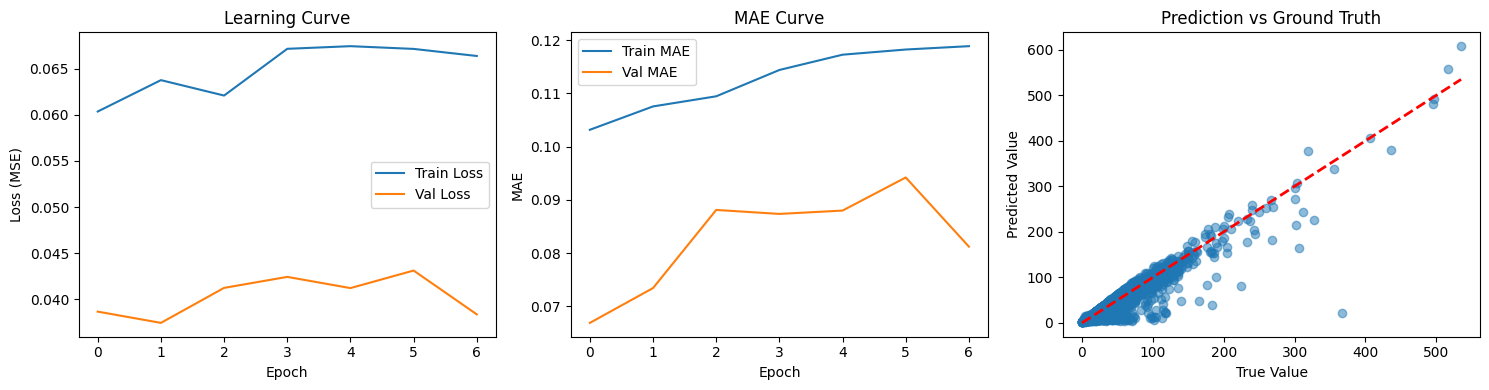

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss (MSE)')
ax[0].legend()
ax[0].set_title('Learning Curve')

ax[1].plot(history.history['mae'], label='Train MAE')
ax[1].plot(history.history['val_mae'], label='Val MAE')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].set_title('MAE Curve')

ax[2].scatter(y_test_real, y_pred_real, alpha=0.5)
ax[2].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
ax[2].set_xlabel('True Value')
ax[2].set_ylabel('Predicted Value')
ax[2].set_title('Prediction vs Ground Truth')

plt.tight_layout()
plt.show()